In [129]:
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [130]:
dataset_name = 'r101'
file_path = '../Dataset/'+dataset_name+'.txt'

# Initialize lists to store vehicle and customer data
vehicle_data = []
customer_data = []

# Read data line by line
with open(file_path, 'r') as file:
    lines = file.readlines()
    
    # Parse vehicle data
    vehicle_info_start = lines.index('VEHICLE\n') + 2
    vehicle_line = lines[vehicle_info_start].strip().split()
    customer_info_start = lines.index('CUSTOMER\n') + 2
    
    # Store vehicle data as a dictionary in a list
    vehicle_data.append({
        'NUMBER': int(vehicle_line[0]),
        'CAPACITY': int(vehicle_line[1])
    })
    
    # Parse customer data
    for line in lines[customer_info_start:]:
        if line.strip():  # Skip any empty lines
            parts = line.strip().split()
            customer_data.append({
                'CUST_NO': int(parts[0]),
                'XCOORD': int(parts[1]),
                'YCOORD': int(parts[2]),
                'DEMAND': int(parts[3]),
                'READY_TIME': int(parts[4]),
                'DUE_DATE': int(parts[5]),
                'SERVICE_TIME': int(parts[6])
            })

# print("Vehicle Data:")
# print(vehicle_data)
# print("\nCustomer Data:")
# for customer in customer_data:  # Show first 5 customers for brevity
#     print(customer)


In [131]:
class Node:
    def __init__(self, id, x, y, demand, ready_time, due_date, service_time):
        self.id = id
        self.is_depot = (id == 0)
        self.x = x
        self.y = y
        self.demand = demand
        self.ready_time = ready_time
        self.due_date = due_date
        self.service_time = service_time
        self.service_time = 10
        self.visited = False
        

In [132]:
class Graph:
    def __init__(self, vehicle_data, customer_data):
        self.vehicle_data = vehicle_data
        self.customer_data = customer_data
        self.nodes = []
        self.vehicle_capacity = vehicle_data[0]['CAPACITY']
        self.num_vehicles = vehicle_data[0]['NUMBER']
        self.setup_nodes()
        self.setup_distance_matrix()
        self.setup_heuristic_matrix()
        self.initialize_pheromone_matrix()
        
    def setup_heuristic_matrix(self):
        self.heuristic_matrix = 1 / self.distance_matrix
        
    def setup_nodes(self):
        for customer in self.customer_data:
            node = Node(customer['CUST_NO'], customer['XCOORD'], customer['YCOORD'], customer['DEMAND'],
                        customer['READY_TIME'], customer['DUE_DATE'], customer['SERVICE_TIME'])
            self.nodes.append(node)
    
    def setup_distance_matrix(self):
        coords = [(node.x, node.y) for node in self.nodes]
        self.distance_matrix = distance_matrix(coords, coords)
        
    def initialize_pheromone_matrix(self):
        n = len(self.nodes)
        self.pheromone_matrix = [[1.0 for _ in range(n)] for _ in range(n)]
    
    def route_distance(self, route):
        distance = 0
        for i in range(len(route) - 1):
            distance += self.distance_matrix[route[i]][route[i + 1]]
        return distance
    
    def update_pheromones(self, ant_solutions, evaporation_rate=0.5):
        # Evaporate pheromones
        for i in range(len(self.pheromone_matrix)):
            for j in range(len(self.pheromone_matrix)):
                self.pheromone_matrix[i][j] = max(self.pheromone_matrix[i][j] * (1 - evaporation_rate), 1e-5)

        
        # Deposit pheromones based on ant solutions
        total_distance = sum(self.route_distance(route) for solution in ant_solutions for route in solution)
        for route in ant_solutions:
            for k in range(len(route) - 1):
                i, j = route[k], route[k + 1]
                self.pheromone_matrix[i][j] += (1 / self.route_distance(route)) / total_distance



In [133]:
def aco_vrp(G, num_ants, num_iterations, alpha=1.5, beta=2.5, evaporation_rate=0.5, q=100):
    """
    Ant Colony Optimization for Vehicle Routing Problem with Time Windows.
    """
    adj_matrix = G.distance_matrix
    capacity_max = G.vehicle_capacity
    num_points = adj_matrix.shape[0]
    ph_matrix = G.pheromone_matrix  # Initial pheromone matrix
    best_solution = None
    best_cost = float('inf')

    def calculate_probabilities(current_node, unvisited, current_time, current_capacity):
        """
        Calculate probabilities of moving to the next node considering time windows and capacity constraints.
        """
        attractiveness = []
        for neighbor in unvisited:
            travel_time = G.distance_matrix[current_node][neighbor]
            arrival_time = current_time + travel_time
            if (G.nodes[neighbor].demand + current_capacity <= capacity_max
                    and arrival_time <= G.nodes[neighbor].due_date):
                tau = ph_matrix[current_node][neighbor] ** alpha
                eta = (1.0 / G.distance_matrix[current_node][neighbor]) ** beta
                attractiveness.append(tau * eta)
            else:
                attractiveness.append(0)
        total = sum(attractiveness)
        if total == 0:  # Avoid division by zero
            return np.zeros(len(unvisited))
        return np.array(attractiveness) / total

    def construct_solution():
        routes = []
        for node in G.nodes:
            node.visited = False

        while any(not node.visited for node in G.nodes[1:]):  # Exclude the depot
            current_node = 0  # Start at depot
            current_time = G.nodes[current_node].ready_time
            current_capacity = 0
            route = [current_node]

            while True:
                unvisited = [i for i in range(1, len(G.nodes)) if not G.nodes[i].visited]
                if not unvisited:
                    break

                probabilities = calculate_probabilities(current_node, unvisited, current_time, current_capacity)
                if not probabilities.any():  # No valid moves
                    break

                next_node = random.choices(unvisited, weights=probabilities)[0]
                travel_time = G.distance_matrix[current_node][next_node]
                arrival_time = current_time + travel_time

                # Validate constraints
                if (current_capacity + G.nodes[next_node].demand <= capacity_max
                        and arrival_time <= G.nodes[next_node].due_date):
                    current_time = max(arrival_time, G.nodes[next_node].ready_time) + G.nodes[next_node].service_time
                    current_capacity += G.nodes[next_node].demand
                    route.append(next_node)
                    G.nodes[next_node].visited = True
                    current_node = next_node
                else:
                    break  # No valid moves; end route

            # Return to depot
            route.append(0)
            routes.append(route)
        return routes

    def calculate_total_distance(route):
        """
        Calculate the total distance of a given route using the distance matrix.
        """
        total_distance = 0
        for i in range(len(route) - 1):
            current_node = route[i]
            next_node = route[i + 1]
            total_distance += G.distance_matrix[current_node][next_node]
        return total_distance

    
    def calculate_cost(routes):
        total_cost = 0
        num_vehicles = len(routes)
        if num_vehicles > G.num_vehicles:  # Penalty for exceeding vehicle limits
            total_cost += 10000 * (num_vehicles - G.num_vehicles)
        for route in routes:
            total_cost += calculate_total_distance(route)
        return total_cost



    def update_pheromones(all_solutions, ph_matrix, evaporation_rate=0.5):
        # Evaporate pheromones
        for i in range(len(ph_matrix)):
            for j in range(len(ph_matrix[i])):
                ph_matrix[i][j] *= (1 - evaporation_rate)
                ph_matrix[i][j] = max(ph_matrix[i][j], 1e-5)  # Prevent near-zero pheromones

        # Deposit pheromones for each solution
        for solution in all_solutions:
            routes = solution  # Each solution is a list of routes
            for route in routes:
                route_distance = calculate_total_distance(route)
                pheromone_deposit = q / max(route_distance, 1e-5)  # Prevent division by zero
                for i in range(len(route) - 1):
                    a, b = route[i], route[i + 1]
                    ph_matrix[a][b] += pheromone_deposit
                    ph_matrix[b][a] = ph_matrix[a][b]  # Ensure symmetry

    # Main ACO loop
    for iteration in range(num_iterations):
        all_solutions = []
        all_costs = []

        for _ in range(num_ants):
            solution = construct_solution()
            cost = calculate_cost(solution)
            all_solutions.append(solution)
            all_costs.append(cost)

            if cost < best_cost:
                best_cost = cost
                best_solution = solution

        # Update pheromones with all solutions
        update_pheromones(all_solutions, G.pheromone_matrix)
        print(f"Iteration {iteration + 1}: Best cost = {best_cost}")

    return best_solution, best_cost


In [134]:
import matplotlib.pyplot as plt

def plot_solution(graph, solution, filename):
    """
    Plot the solution of the VRP problem and show the details of departure and arrival times.
    Args:
        graph: Graph object containing node information.
        solution: List of routes (e.g., [[0, 1, 3, 0], [0, 2, 4, 0], ...]).
    """
    # Extract node coordinates
    x_coords = [node.x for node in graph.nodes]
    y_coords = [node.y for node in graph.nodes]

    # Create the plot
    plt.figure(figsize=(10, 8))

    # Plot all nodes
    plt.scatter(x_coords, y_coords, color="blue", label="Customers", zorder=5)
    
    # Highlight the depot (node 0)
    plt.scatter(x_coords[0], y_coords[0], color="black", label="Depot", zorder=5, s=100)

    # Annotate each node with its ID
    for node in graph.nodes:
        plt.text(node.x, node.y, f"{node.id}", fontsize=8, ha="right", va="bottom")

    # Plot each route and display start/end times for each customer
    for route, route_times in solution:
        route_coords_x = [x_coords[i] for i in route]
        route_coords_y = [y_coords[i] for i in route]
        plt.plot(route_coords_x, route_coords_y, label=f"Route {solution.index((route, route_times)) + 1}")

        # Display start and end times for each customer in the route
        for i, node_id in enumerate(route[1:-1]):  # Exclude depot (node 0) and return
            start_time, end_time = route_times[i]
            plt.text(x_coords[node_id], y_coords[node_id], f"Start: {start_time}\nEnd: {end_time}", fontsize=8, ha="center", va="center")

        # Annotate depot time (arrival and departure)
        start_time, end_time = route_times[-1]
        plt.text(x_coords[0], y_coords[0], f"Depot Start: {start_time}\nDepot End: {end_time}", fontsize=8, ha="center", va="center", color="red")

    # Customize the plot
    plt.title(f"Vehicle Routing Problem Solution --- {filename}")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid()
    plt.show()



C:\Users\Alexandre\AppData\Local\Temp\ipykernel_16800\1037172100.py:14: RuntimeWarning: divide by zero encountered in divide
  self.heuristic_matrix = 1 / self.distance_matrix


Iteration 1: Best cost = 122989.7434653077
Iteration 2: Best cost = 82452.27154432987
Iteration 3: Best cost = 72338.3632094701
Iteration 4: Best cost = 72321.07961362736
Iteration 5: Best cost = 62363.51771286324
Iteration 6: Best cost = 62363.51771286324
Iteration 7: Best cost = 62246.27213150334
Iteration 8: Best cost = 62246.27213150334
Iteration 9: Best cost = 62246.27213150334
Iteration 10: Best cost = 62238.9549528934
Iteration 11: Best cost = 62238.9549528934
Iteration 12: Best cost = 52279.39825751295
Iteration 13: Best cost = 52279.39825751295
Iteration 14: Best cost = 52279.39825751295
Iteration 15: Best cost = 52279.39825751295
Iteration 16: Best cost = 52279.39825751295
Iteration 17: Best cost = 52279.39825751295
Iteration 18: Best cost = 52279.39825751295
Iteration 19: Best cost = 52279.39825751295
Iteration 20: Best cost = 52265.69789366824
Iteration 21: Best cost = 52265.69789366824
Iteration 22: Best cost = 52265.69789366824
Iteration 23: Best cost = 52265.69789366824


ValueError: too many values to unpack (expected 2)

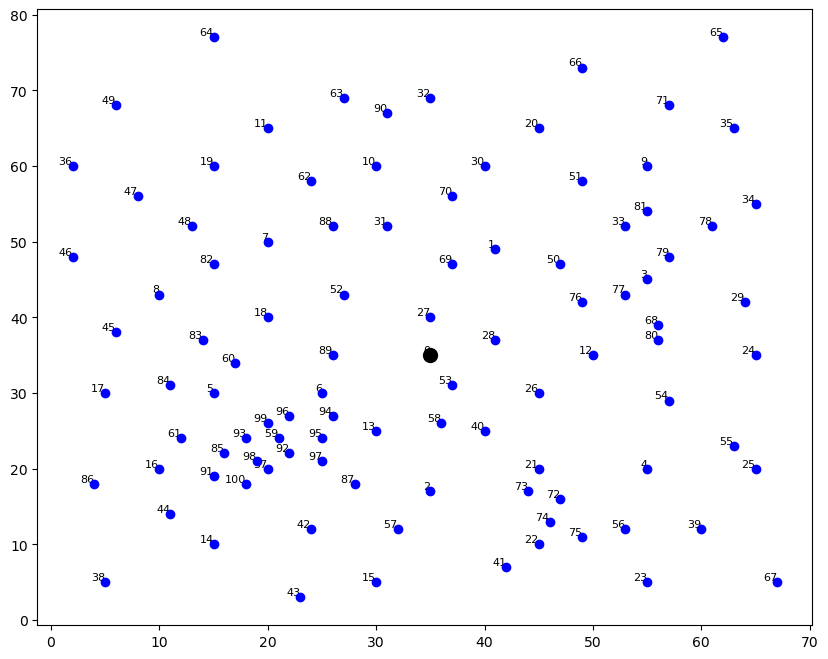

In [136]:
G = Graph(vehicle_data, customer_data)

# Run ACO
best_solution_data, best_cost = aco_vrp(
    G,
    num_ants=50, num_iterations=100, alpha=1.5, beta=2.5, evaporation_rate=0.5, q=100
)

print("Best cost: " + str(best_cost))
i = 1
for route in best_solution_data:  
    print("Route " + str(i) +": " + str(route))
    i = i + 1
plot_solution(G, best_solution_data, dataset_name)